<a href="https://colab.research.google.com/github/nuunblues/Astronomy/blob/main/Astronomyproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PHANGS-HST+JWST notebook for retrieval and plotting of cluster and multi-scale stellar association catalogs, with all image products downloaded in realtime via calls to the phangs interactive viewer (aka sundog).

We use PHANGS HLSP resources (images and catalogs) hosted at MAST, specifically:

A full set of interactive viewer links are found in the data access table contained on the PHANGS HLSP webpage [PHANGS HLSP webpage](PHANGS HLSP webpage).

Interactive viewer example for NGC1566

DR4 - Catalog Release 2 (December 15, 2023) Catalogs of the observed properties of star clusters and compact associations for the full sample of 38 PHANGS-HST spiral galaxies (plus 1 companion dwarf galaxy) are provided. The catalogs include photometry for a total of ~100,000 star clusters and compact associations (Maschmann, Lee, Thilker, Whitmore, et al. 2024). Catalogs containing the physical properties based on SED fitting of the HST NUV-U-B-V-I photometry will be provided in an upcoming delivery.

DR3 - Catalog Release 1 (February 08, 2022) A separate set of catalogs for multi-scale associations for five galaxies (NGC 1433, NGC 1566, NGC 1559, NGC 3351, NGC 3627) are being released as part of DR3.
With the original code written in collaberation with David Thilkers, Jessica Sutters and Beatrice Archer.

In [1]:
#IMPORTANT NOTES REGARDING USAGE!
#if using this code in .py form rather than .ipynb, or the .ipynb in jupyter notebook... COMMENT OUT the 'pip install' lines
#if using this code as .ipynb in a jupyter notebook rather than google colab... UNCOMMENT %matplotlib notebook line if you want interactivity

#select PHANGS-HST galaxy
#for now limited to ngc1566, ngc1559, ngc1433, ngc3351, ngc3627  due to reliance on currently public PHANGS MSA catalogs, and
galaxystr='ngc1566'  #in the case of ngc3351 and ngc3627, must tack 'mosaic' onto the end of galaxystr (e.g. 'ngc3351mosaic') due to the viewer file names
galaxy=galaxystr.replace('mosaic','')

In [3]:
#uncomment the line below if running in a jupyter notebook window and interactivity with plots is desired
#%matplotlib notebook

import numpy as np
from astropy.io import fits
import glob
import urllib3
import matplotlib.pyplot as plt

In [4]:
import os
#needed in order to use os.system
from IPython.display import Javascript
Javascript('''google.colab.output.enable(true);''')

<IPython.core.display.Javascript object>

In [5]:
#use astroquery to get galaxy position
os.system('pip install astroquery')
from astropy.coordinates import SkyCoord
from astroquery.simbad import Simbad
from astropy import units as u
from astroquery.ned import Ned

result_table = Ned.query_object(galaxy)
print(result_table) # an astropy.table.Table
rastr=str(round(result_table['RA'][0], 5))
decstr=str(round(result_table['DEC'][0], 5))

<ipython-input-5-894472f5b432>:6: DeprecationWarning: the ``ned`` module has been moved to astroquery.ipac.ned, please update your imports.
  from astroquery.ned import Ned


No. Object Name     RA        DEC     ... Positions Redshift Points Diameter Points Associations
                 degrees    degrees   ...                                                       
--- ----------- ---------- ---------- ... --------- --------------- --------------- ------------
  1    NGC 1566   65.00164  -54.93794 ...        89              82              17            0


In [6]:
#download sundog cutouts in png, RGBfits, and F275W-only FITS format (the later is for WCS purposes)

#change cutout size manually for this demo 'size=' below (in pixels)
sizestr='3000,1800' # pixels
#this url fetches from the HLSP incarnation of the viewer/cutout interface, first a color png
url = 'https://archive.stsci.edu/cgi-bin/hla/fitscut.cgi?'\
+'red=%2Fhlsps%2Fphangs-hst%2F'+galaxystr+'%2Fhlsp_phangs-hst_hst_wfc3-uvis_'+galaxystr+'_f814w_v1_exp-drc-sci.fits&'\
+'green=%2Fhlsps%2Fphangs-hst%2F'+galaxystr+'%2Fhlsp_phangs-hst_hst_wfc3-uvis_'+galaxystr+'_f555w_v1_exp-drc-sci.fits&'\
+'blue=%2Fhlsps%2Fphangs-hst%2F'+galaxystr+'%2Fhlsp_phangs-hst_hst_wfc3-uvis_'+galaxystr+'_f438w_v1_exp-drc-sci.fits&'\
+'align=1&reference=%2Fhlsps%2Fphangs-hst%2F'+galaxystr+'%2Fhlsp_phangs-hst_hst_wfc3-uvis_'+galaxystr+'_f275w_v1_exp-drc-sci.fits&'\
+'maxzoom=5&tile=&download=1&format=png&ra='+rastr+'&dec='+decstr+'&corner=0&size='+sizestr+'&zoom=1.0'
http = urllib3.PoolManager()

with http.request('GET', url, preload_content=False) as response:
  content_length = response.info()['Content-Length']
  bytes_so_far = 0

  with open('sundog.png', 'wb') as f:
    for chunk in response.stream(32768):
      bytes_so_far += len(chunk)
      f.write(chunk)
      percent_complete = bytes_so_far / int(content_length) * 100
#      print(f"Downloaded {percent_complete:.2f}%")
  print(f"Downloaded {percent_complete:.2f}%")

#now change the request to an RGB fits file
urlfits=url.replace('png','fits')

with http.request('GET', urlfits, preload_content=False) as response:
  content_length = response.info()['Content-Length']
  bytes_so_far = 0

  with open('sundog.fits', 'wb') as f:
    for chunk in response.stream(32768):
      bytes_so_far += len(chunk)
      f.write(chunk)
      percent_complete = bytes_so_far / int(content_length) * 100
#      print(f"Downloaded {percent_complete:.2f}%")
  print(f"Downloaded {percent_complete:.2f}%")

#now a url to get the F275W fits cutout (for WCS)
url275fits = 'https://archive.stsci.edu/cgi-bin/hla/fitscut.cgi?'\
+'red=%2Fhlsps%2Fphangs-hst%2F'+galaxystr+'%2Fhlsp_phangs-hst_hst_wfc3-uvis_'+galaxystr+'_f275w_v1_exp-drc-sci.fits&'\
+'maxzoom=5&tile=&download=1&format=fits&ra='+rastr+'&dec='+decstr+'&corner=0&size='+sizestr+'&zoom=1.0'

with http.request('GET', url275fits, preload_content=False) as response:
  content_length = response.info()['Content-Length']
  bytes_so_far = 0

  with open('sundog_f275w.fits', 'wb') as f:
    for chunk in response.stream(32768):
      bytes_so_far += len(chunk)
      f.write(chunk)
      percent_complete = bytes_so_far / int(content_length) * 100
#      print(f"Downloaded {percent_complete:.2f}%")
  print(f"Downloaded {percent_complete:.2f}%")


Downloaded 100.00%
Downloaded 100.00%
Downloaded 100.00%


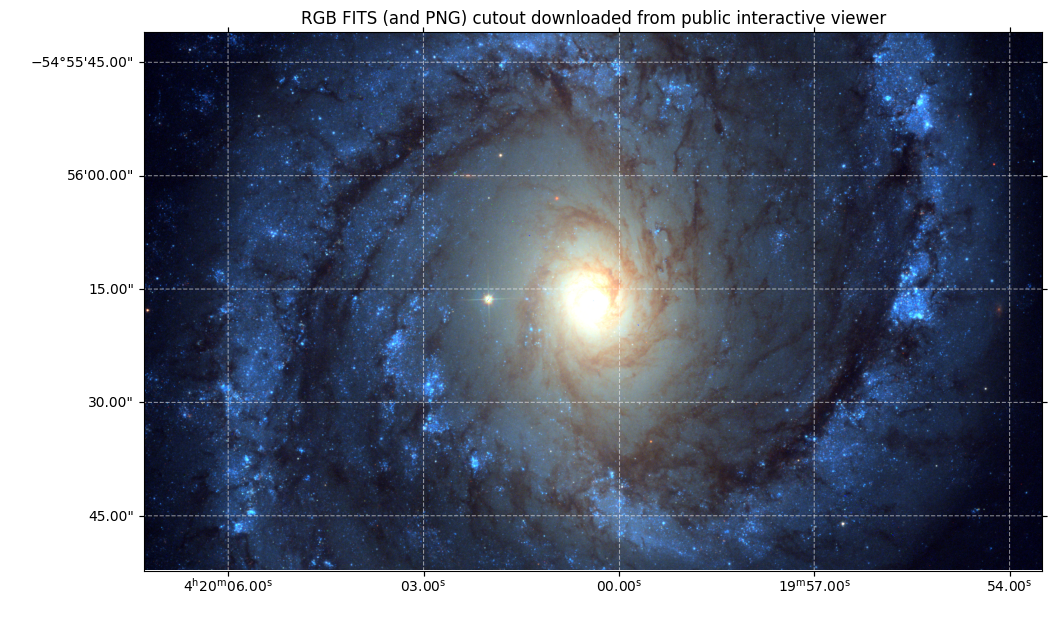

In [7]:
# read the downloaded png image and display it with WCS coordinates from the downloaded F275W fits file header

from astropy.visualization import ImageNormalize, AsinhStretch
from astropy.wcs import WCS

image_data = plt.imread('sundog.png')

# Flip the image vertically.  --OTHERWISE IMAGE AND WCS DO NOT AGREE
image_data = np.flipud(image_data)

with fits.open('sundog_f275w.fits') as hdul:
    wcs = WCS(hdul[0].header)#.dropaxis(2) #DROPAXIS FOR RGBfits ONLY

norm = ImageNormalize(image_data, stretch=AsinhStretch())

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(1, 1, 1, projection=wcs)
ax.imshow(image_data, origin='lower', norm=norm)

ax.coords['ra'].set_major_formatter('hh:mm:ss.ss')
ax.coords['dec'].set_major_formatter('dd:mm:ss.ss')

ax.grid(color='white', alpha=0.5, linestyle='--')
ax.set_xlabel('RA (J2000)', color='white')
ax.set_ylabel('Dec (J2000)', color='white')

ax.set_title('RGB FITS (and PNG) cutout downloaded from public interactive viewer')
plt.show()


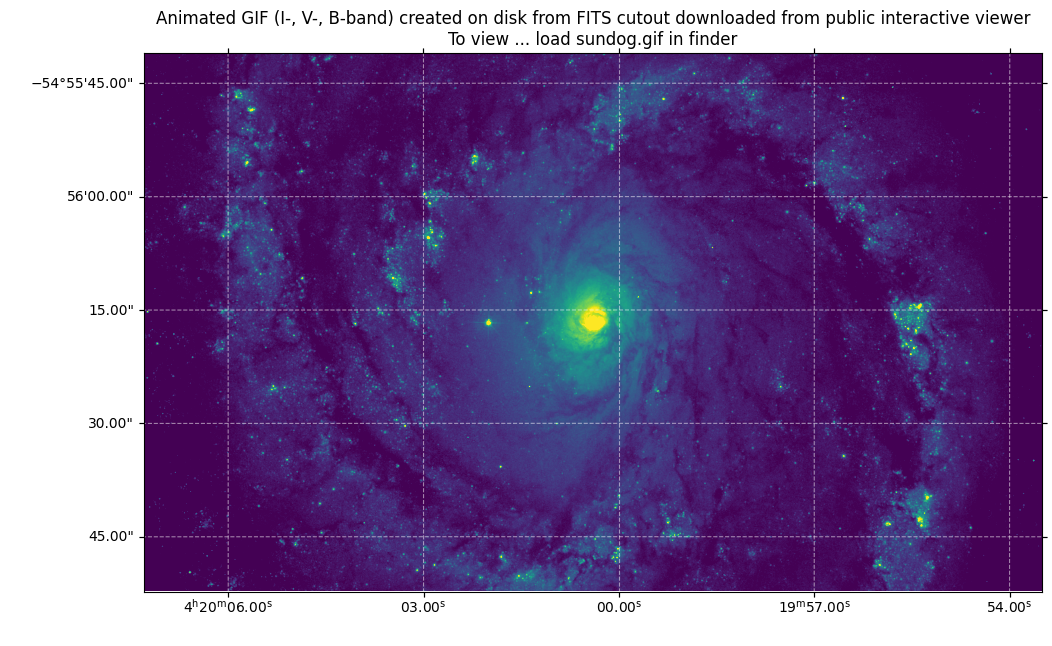

In [8]:
# display the downloaded multi-extension RGB fits file as an animated gif
# in colab the image doesn't display as an animation, but the file written (sundog.gif) is animated via mac 'finder'
from matplotlib import animation
from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(1, 1, 1, projection=wcs)

with fits.open('sundog.fits') as hdul:
  ims = []
  for i in range(hdul[0].data.shape[0]):
    image_data_band=hdul[0].data[i, :, :]
    image_data_band=np.flipud(image_data_band)  # DESPITE FLIPPING THE SINGLE BANDS, THE IMAGE IN THE ANIMATED GIF IS UPSIDE DOWN!?
    im = ax.imshow(image_data_band, origin='lower', norm=norm)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True, repeat_delay=5000)

ax.coords['ra'].set_major_formatter('hh:mm:ss.ss')
ax.coords['dec'].set_major_formatter('dd:mm:ss.ss')

ax.grid(color='white', alpha=0.5, linestyle='--')
ax.set_xlabel('RA (J2000)', color='white')
ax.set_ylabel('Dec (J2000)', color='white')

ax.set_title('Animated GIF (I-, V-, B-band) created on disk from FITS cutout downloaded from public interactive viewer\nTo view ... load sundog.gif in finder')

#saved GIF can be viewed as animated in the mac 'finder' application
ani.save('sundog.gif', writer='pillow')

plt.show()


In [ ]:
# interpret a string containing a sequence of floats as a series of x,y vertices

import re

def interpret_vertices(vertex_string):
  """
  Interprets a string containing a sequence of floats as a series of x,y vertices.

  Args:
    vertex_string: A string containing a sequence of floats, separated by spaces.

  Returns:
    A list of tuples, where each tuple represents an (x, y) vertex.
  """

  # Remove any non-numeric characters from the string.
  vertex_string = re.sub(r"[^\d\s\.\-]", "", vertex_string)

  # Split the string into a list of floats.
  vertices = vertex_string.split()

  # Convert the list of floats into a list of tuples.
  vertices = [(float(vertices[i]), float(vertices[i+1])) for i in range(0, len(vertices), 2)]

  return vertices

# Example usage:
#vertex_string = "10 10 20 20 30 30"
#vertices = interpret_vertices(vertex_string)
#print(vertices)

In [ ]:
# download https://archive.stsci.edu/hlsps/phangs-cat/bundles/hlsp_phangs-cat_hst_wfc3_'+galaxy+'_multi_v1_assoc-cats.tar.gz and unpack into a subdirectory called assoc_catalogs
os.system('mkdir assoc_catalogs')

url = 'https://archive.stsci.edu/hlsps/phangs-cat/bundles/hlsp_phangs-cat_hst_wfc3_'+galaxy+'_multi_v1_assoc-cats.tar.gz'
http = urllib3.PoolManager()

with http.request('GET', url, preload_content=False) as response:
  content_length = response.info()['Content-Length']
  bytes_so_far = 0

  with open(url.replace('https://archive.stsci.edu/hlsps/phangs-cat/bundles/',''), 'wb') as f:
    for chunk in response.stream(32768):
      bytes_so_far += len(chunk)
      f.write(chunk)
      percent_complete = bytes_so_far / int(content_length) * 100
#      print(f"Downloaded {percent_complete:.2f}%")
  print(f"Downloaded {percent_complete:.2f}%")

print('Unpacking...')
os.system('tar -xzvf hlsp_phangs-cat_hst_wfc3_'+galaxy+'_multi_v1_assoc-cats.tar.gz -C assoc_catalogs')
for item in glob.glob('assoc_catalogs/**/**', recursive=True): print(item)

In [ ]:
#read in the ds9 region file containing the multi-scale associations defined in the NUV at 64 pc scale
from matplotlib.patches import Polygon
import glob

msafile=glob.glob('*/*/*/*/*/*'+galaxy+'*nuv*ws64pc*region.reg',recursive=True)
#print(msafile)
with open(msafile[0]) as f:
    shapes = []
    for line in f:
        if line.startswith(' polygon'):
            vertices = interpret_vertices(line)
            #print(vertices)
            shapes.append(Polygon(vertices))
    #print(shapes)

In [ ]:
# convert the matplotlib polygons defined as (right acension, declination) in the shapes list to PolygonSkyRegions
os.system('pip install regions')
from astropy.coordinates import SkyCoord
from regions import PolygonSkyRegion

def convert_polygon_to_sky_region(polygon):
  """
  Converts a matplotlib Polygon to an astropy.coordinates.PolygonSkyRegion.

  Args:
    polygon: A matplotlib Polygon object.

  Returns:
    An astropy.coordinates.PolygonSkyRegion object.
  """

  # Get the vertices of the polygon.
  vertices = np.array(polygon.get_xy()).T

  # Convert the vertices to sky coordinates.
  sky_coords = SkyCoord(vertices[0], vertices[1], frame='icrs', unit='deg')

  # Create a PolygonSkyRegion object.
  sky_region = PolygonSkyRegion(sky_coords)#, frame='icrs')

  return sky_region

# Convert the matplotlib polygons to PolygonSkyRegions.
sky_regions = [convert_polygon_to_sky_region(polygon) for polygon in shapes]

# Print the PolygonSkyRegions.
#for sky_region in sky_regions:
#  print(sky_region)


In [ ]:
# read the downloaded png image and display it with WCS coordinates from the downloaded F275W fits file header, then overplot each PolygonSkyRegion in sky_regions

# Read the downloaded PNG image.
image_data = plt.imread('sundog.png')

# Flip the image vertically.  --OTHERWISE IMAGE AND WCS+REGIONS DO NOT AGREE
image_data = np.flipud(image_data)

# Get the WCS coordinates from the downloaded FITS file header.
with fits.open('sundog_f275w.fits') as hdul:
    wcs = WCS(hdul[0].header)#.dropaxis(2) #DROPAXIS FOR RGBfits ONLY

# Create a figure and axes.
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(1, 1, 1, projection=wcs)

# Display the image with WCS coordinates.
ax.imshow(image_data, origin='lower')

# Overplot each PolygonSkyRegion.
for sky_region in sky_regions:
    pixel_region = sky_region.to_pixel(wcs)
    pixel_region.plot(ax=ax, facecolor='none', edgecolor='deepskyblue', linewidth=0.75)
    #sky_region.plot(ax=ax, facecolor='none', edgecolor='red')

# Set the labels and grid.
ax.set_xlabel('RA (J2000)')
ax.set_ylabel('Dec (J2000)')
ax.grid(color='white', alpha=0.5, linestyle='--')
ax.set_title('RGB FITS (and PNG) cutout with 64pc multi-scale stellar associations')

# Show the plot.
plt.show()


In [ ]:
# download https://archive.stsci.edu/hlsps/phangs-cat/dr4/bundles/hlsp_phangs-cat_hst_acs-uvis_'+galaxy+'_multi_v1_cats.tar.gz and unpack into a subdirectory called cluster_catalogs
os.system('mkdir cluster_catalogs')

url = 'https://archive.stsci.edu/hlsps/phangs-cat/dr4/bundles/hlsp_phangs-cat_hst_acs-uvis_'+galaxy+'_multi_v1_cats.tar.gz'
http = urllib3.PoolManager()

with http.request('GET', url, preload_content=False) as response:
  content_length = response.info()['Content-Length']
  bytes_so_far = 0

  with open(url.replace('https://archive.stsci.edu/hlsps/phangs-cat/dr4/bundles/',''), 'wb') as f:
    for chunk in response.stream(32768):
      bytes_so_far += len(chunk)
      f.write(chunk)
      percent_complete = bytes_so_far / int(content_length) * 100
#      print(f"Downloaded {percent_complete:.2f}%")
  print(f"Downloaded {percent_complete:.2f}%")

print('Unpacking...')
os.system('tar -xzvf hlsp_phangs-cat_hst_acs-uvis_'+galaxy+'_multi_v1_cats.tar.gz -C cluster_catalogs')
for item in glob.glob('cluster_catalogs/**/**', recursive=True): print(item)

In [ ]:
# read hlsp_phangs-cat_hst_uvis_'+galaxy+'_multi_v1_obs-machine-cluster-class12.fits using astropy.table

from astropy.table import Table

cluster_cat = Table.read('cluster_catalogs/catalogs/hlsp_phangs-cat_hst_uvis_'+galaxy+'_multi_v1_obs-machine-cluster-class12.fits')
#print(cluster_cat)

In [ ]:
#this cell brings everything together and plots the color cutout with associations and clusters marked
from regions import CircleSkyRegion
from astropy import units as u

# Convert the astropy table to a list of CircleSkyRegions.
circle_sky_regions = []
for row in cluster_cat:
  circle_sky_regions.append(CircleSkyRegion(
    SkyCoord(row['PHANGS_RA'], row['PHANGS_DEC'], frame='icrs', unit='deg'),
    radius=4.*0.03962 * u.arcsec
  ))

# Read the downloaded PNG image.
image_data = plt.imread('sundog.png')

# Flip the image vertically.  --OTHERWISE IMAGE AND WCS+REGIONS DO NOT AGREE
image_data = np.flipud(image_data)

# Get the WCS coordinates from the downloaded FITS file header.
with fits.open('sundog_f275w.fits') as hdul:
    wcs = WCS(hdul[0].header)#.dropaxis(2) #DROPAXIS FOR RGBfits ONLY

# Create a figure and axes.
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot(1, 1, 1, projection=wcs)

# Display the image with WCS coordinates.
ax.imshow(image_data, origin='lower')

# Overplot each PolygonSkyRegion.
for sky_region in sky_regions:
    pixel_region = sky_region.to_pixel(wcs)
    pixel_region.plot(ax=ax, facecolor='none', edgecolor='deepskyblue', linewidth=0.75)
    #sky_region.plot(ax=ax, facecolor='none', edgecolor='red')

# Overplot each CircleSkyRegion on the display of sundog.png, changing color according to cluster morphological class
for idx, circle_sky_region in enumerate(circle_sky_regions):
  pixel_region = circle_sky_region.to_pixel(wcs)
  if cluster_cat['PHANGS_CLUSTER_CLASS_ML_VGG'][idx]==1: clustercolor='red'
  if cluster_cat['PHANGS_CLUSTER_CLASS_ML_VGG'][idx]==2: clustercolor='lime'
  pixel_region.plot(ax=ax, facecolor='none', edgecolor=clustercolor, linewidth=0.75)

# Set the labels and grid.
ax.set_xlabel('RA (J2000)')
ax.set_ylabel('Dec (J2000)')
ax.grid(color='white', alpha=0.5, linestyle='--')
ax.set_title('RGB FITS (and PNG) cutout with 64pc multi-scale stellar associations and Class 1+2 clusters')

# Show the plot.
plt.show()


In [ ]:
# randomly select nclust rows from cluster_cat and generate a subset catalog

nclust = 16
cluster_cat_subset = cluster_cat[np.random.randint(len(cluster_cat), size=nclust)]

In [ ]:
# fetch the cluster subimages
# for this demonstration just autoscale, do not tune RGB intensity transfer functions/limits to produce equivalent hue for equivalent relative intensity ratios

refband = 'f275w' #HST F275W NUV   # in the present implementation this produces F814W/F555W/F438W RGB subimages on HST pixel grid
#refband = 'f200w' #JWST NIRCam F200W NIR  # produces F300M/F200W/F814W RGB subimages on NIRCam-short pixel grid (matching extent to HST-only subimages)

# Create a list to store 29 HST-pixel wide subimages, or 37 NIRCam-short-pixel wide subimages
subimages = []

print('Downloading '+str(nclust)+' cluster subimages...')
for idx, clusterid in enumerate(cluster_cat_subset):

  if refband == 'f275w': npix=29
  if refband == 'f200w': npix=37
  npixstr=str(npix)
  rastr=str(cluster_cat_subset['PHANGS_RA'][idx])
  decstr=str(cluster_cat_subset['PHANGS_DEC'][idx])

  if refband == 'f275w': url = 'https://archive.stsci.edu/cgi-bin/hla/fitscut.cgi?red=%2Fhlsps%2Fphangs-hst%2F'+galaxystr+'%2Fhlsp_phangs-hst_hst_wfc3-uvis_'+galaxystr+'_f814w_v1_exp-drc-sci.fits&green=%2Fhlsps%2Fphangs-hst%2F'+galaxystr+'%2Fhlsp_phangs-hst_hst_wfc3-uvis_'+galaxystr+'_f555w_v1_exp-drc-sci.fits&blue=%2Fhlsps%2Fphangs-hst%2F'+galaxystr+'%2Fhlsp_phangs-hst_hst_wfc3-uvis_'+galaxystr+'_f438w_v1_exp-drc-sci.fits&align=1&reference=%2Fhlsps%2Fphangs-hst%2F'+galaxystr+'%2Fhlsp_phangs-hst_hst_wfc3-uvis_'+galaxystr+'_f275w_v1_exp-drc-sci.fits&tile=&download=1&format=png&ra='+rastr+'&dec='+decstr+'&corner=0&size='+npixstr+'&zoom=1'
  if refband == 'f200w': url = 'https://sundog.stsci.edu/cgi-bin/fitscut.cgi?red=%2Fphangs%2Fdata%2F'+galaxystr+'%2Fprocessed%2Ff300m%2F'+galaxystr+'_nircam_f300m_i2d.fits&green=%2Fphangs%2Fdata%2F'+galaxystr+'%2Fprocessed%2Ff200w%2F'+galaxystr+'_nircam_f200w_i2d.fits&blue=%2Fphangs%2Fdata%2F'+galaxystr+'%2Fprocessed%2Ff814w%2F'+galaxystr+'_uvis_f814w_exp_drc_sci.fits&align=1&reference=%2Fphangs%2Fdata%2F'+galaxystr+'%2Fprocessed%2Ff200w%2F'+galaxystr+'_nircam_f200w_i2d.fits&tile=&download=1&format=png&ra='+rastr+'&dec='+decstr+'&corner=0&size='+npixstr+'&zoom=1.0'
  http = urllib3.PoolManager()

  with http.request('GET', url, preload_content=False) as response:
    content_length = response.info()['Content-Length']
    bytes_so_far = 0

    with open('sundog_subimage.png', 'wb') as f:
      for chunk in response.stream(32768):
        bytes_so_far += len(chunk)
        f.write(chunk)

  image_data = plt.imread('sundog_subimage.png')
  image_data = np.flipud(image_data)
  subimages.append(image_data)

print('Complete!')

In [ ]:
# display the cluster subimages as a roughly square montage

gridsize=int(np.ceil(np.sqrt(nclust)))
fig, axes = plt.subplots(gridsize, gridsize, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    if (i+1 <= nclust):
      ax.imshow(subimages[i], origin='lower')
      ax.set_xticks([])
      ax.set_yticks([])
    else: ax.set_axis_off()

plt.subplots_adjust(hspace=0.15, wspace=0.15)
plt.show()


In [ ]:
#HERE WE REPEAT THE ABOVE TWO CELLS, BUT NOW REQUEST F300M/F200W/F814W RGB subimages on NIRCam-short pixel grid

# fetch the cluster subimages
# for this demonstration just autoscale, do not tune RGB intensity transfer functions/limits to produce equivalent hue for equivalent relative intensity ratios

#refband = 'f275w' #HST F275W NUV   # in the present implementation this produces F814W/F555W/F438W RGB subimages on HST pixel grid
refband = 'f200w' #JWST NIRCam F200W NIR  # produces F300M/F200W/F814W RGB subimages on NIRCam-short pixel grid (matching extent to HST-only subimages)

# Create a list to store 29 HST-pixel wide subimages, or 37 NIRCam-short-pixel wide subimages
subimages = []

print('Downloading '+str(nclust)+' cluster subimages...')
for idx, clusterid in enumerate(cluster_cat_subset):

  if refband == 'f275w': npix=29
  if refband == 'f200w': npix=37
  npixstr=str(npix)
  rastr=str(cluster_cat_subset['PHANGS_RA'][idx])
  decstr=str(cluster_cat_subset['PHANGS_DEC'][idx])

  if refband == 'f275w': url = 'https://archive.stsci.edu/cgi-bin/hla/fitscut.cgi?red=%2Fhlsps%2Fphangs-hst%2F'+galaxystr+'%2Fhlsp_phangs-hst_hst_wfc3-uvis_'+galaxystr+'_f814w_v1_exp-drc-sci.fits&green=%2Fhlsps%2Fphangs-hst%2F'+galaxystr+'%2Fhlsp_phangs-hst_hst_wfc3-uvis_'+galaxystr+'_f555w_v1_exp-drc-sci.fits&blue=%2Fhlsps%2Fphangs-hst%2F'+galaxystr+'%2Fhlsp_phangs-hst_hst_wfc3-uvis_'+galaxystr+'_f438w_v1_exp-drc-sci.fits&align=1&reference=%2Fhlsps%2Fphangs-hst%2F'+galaxystr+'%2Fhlsp_phangs-hst_hst_wfc3-uvis_'+galaxystr+'_f275w_v1_exp-drc-sci.fits&tile=&download=1&format=png&ra='+rastr+'&dec='+decstr+'&corner=0&size='+npixstr+'&zoom=1'
  if refband == 'f200w': url = 'https://sundog.stsci.edu/cgi-bin/fitscut.cgi?red=%2Fphangs%2Fdata%2F'+galaxystr+'%2Fprocessed%2Ff300m%2F'+galaxystr+'_nircam_f300m_i2d.fits&green=%2Fphangs%2Fdata%2F'+galaxystr+'%2Fprocessed%2Ff200w%2F'+galaxystr+'_nircam_f200w_i2d.fits&blue=%2Fphangs%2Fdata%2F'+galaxystr+'%2Fprocessed%2Ff814w%2F'+galaxystr+'_uvis_f814w_exp_drc_sci.fits&align=1&reference=%2Fphangs%2Fdata%2F'+galaxystr+'%2Fprocessed%2Ff200w%2F'+galaxystr+'_nircam_f200w_i2d.fits&tile=&download=1&format=png&ra='+rastr+'&dec='+decstr+'&corner=0&size='+npixstr+'&zoom=1.0'
  http = urllib3.PoolManager()

  with http.request('GET', url, preload_content=False) as response:
    content_length = response.info()['Content-Length']
    bytes_so_far = 0

    with open('sundog_subimage.png', 'wb') as f:
      for chunk in response.stream(32768):
        bytes_so_far += len(chunk)
        f.write(chunk)

  image_data = plt.imread('sundog_subimage.png')
  image_data = np.flipud(image_data)
  subimages.append(image_data)

print('Complete!')

In [ ]:
# display the cluster subimages as a roughly square montage

gridsize=int(np.ceil(np.sqrt(nclust)))
fig, axes = plt.subplots(gridsize, gridsize, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    if (i+1 <= nclust):
      ax.imshow(subimages[i], origin='lower')
      ax.set_xticks([])
      ax.set_yticks([])
    else: ax.set_axis_off()

plt.subplots_adjust(hspace=0.15, wspace=0.15)
plt.show()